# 0. Meta

## 0.1. Packages

In [60]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.cm import viridis


## 0.2. Functions

# 1. Data import

The data originates from Kaggle, specifically the dataset titled ["Cars Germany"](https://www.kaggle.com/datasets/ander289386/cars-germany/data). Spanning from 2011 to 2021, the dataset encompasses information sourced from AutoScout24, one of Europe's major car markets for new and used vehicles. The data collection and scraping were facilitated by an automated tool developed at ZenRows, capturing essential details such as make, model, mileage, horsepower, and more.

In [61]:
df_raw = pd.read_csv("../data/raw/autoscout24.csv")

# 2. Initial Data exploration

## 2.1. Structure of Data

Shape and dimensions of raw data.

In [62]:
print(f"Shape of data: {df_raw.shape}")
print(f"Dimensionality of data: {df_raw.shape[0]/df_raw.shape[1]}")

Shape of data: (46405, 9)
Dimensionality of data: 5156.111111111111


Dimensionality: very low (n/p ~  5156).

## 2.2. Scale of Measure

Check for correct assignment of scales.

In [63]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46405 entries, 0 to 46404
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mileage    46405 non-null  int64  
 1   make       46405 non-null  object 
 2   model      46262 non-null  object 
 3   fuel       46405 non-null  object 
 4   gear       46223 non-null  object 
 5   offerType  46405 non-null  object 
 6   price      46405 non-null  int64  
 7   hp         46376 non-null  float64
 8   year       46405 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.2+ MB


Scales are correctly assigned. However, "offerType" could be of scale "ordinal".Check unique levels of "offerType".

In [64]:
df_raw["offerType"].unique()

array(['Used', 'Demonstration', "Employee's car", 'Pre-registered', 'New'],
      dtype=object)

The variable "offerType" represent an ordinal variable, as there is an implicit ranking order:

'Used'  < "Employee's car" < 'Demonstration' < 'Pre-registered' < 'New'

## 2.2. Missing Entries

Total number and proportion of missing entries.

In [65]:
total_rows_with_missing_values = df_raw.isnull().any(axis=1).sum()
print(f"Total number of rows with at least one missing entry: {total_rows_with_missing_values}")
print(f"Proportion of rows with at least one missing entry: {round(total_rows_with_missing_values/df_raw.shape[0]*100,2)}%")

Total number of rows with at least one missing entry: 334
Proportion of rows with at least one missing entry: 0.72%


Only very little amount of rows contain missing entries. 

Visualize missing values for each column with heatmap and bar charts.

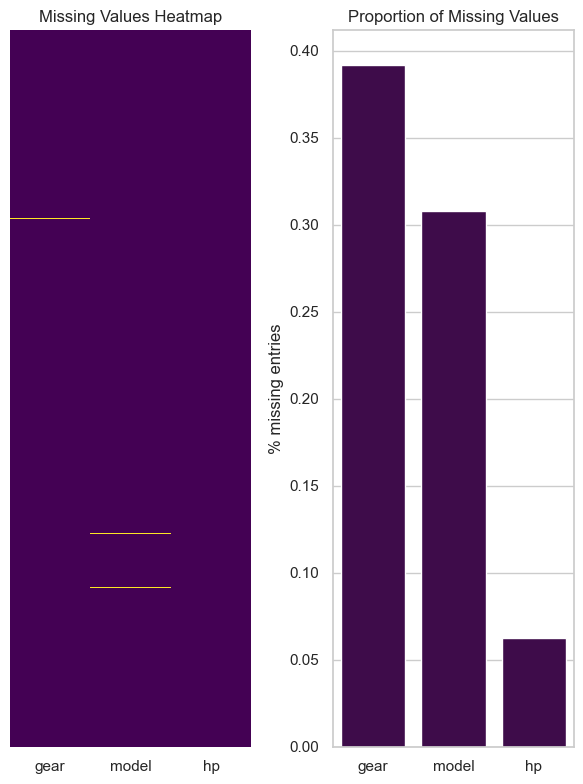

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(6, 8))

sns.heatmap(
    df_raw[df_raw.isnull().sum().sort_values(ascending=False).index]
        .loc[:, df_raw.isnull().sum().sort_values(ascending=False) > 0]
        .isnull(),
    cbar=False, cmap='viridis',
    yticklabels=False,
    ax=axes[0]  
)
axes[0].set_title('Missing Values Heatmap')


sns.barplot(
    x=df_raw.isnull().sum()[df_raw.isnull().sum() > 0].sort_values(ascending=False).index,
    y=(100*df_raw.isnull().sum()[df_raw.isnull().sum() > 0]/df_raw.shape[0]).sort_values(ascending=False),
    color=viridis(0),
    ax=axes[1]  
)
axes[1].set_title('Proportion of Missing Values')
axes[1].set_xlabel('')
axes[1].set_ylabel('% missing entries')

plt.savefig('../reports/figures/missing_entries.png')
plt.tight_layout()  
plt.show()

## 2.3. Categorial Variables

### 2.3.1. Counts per categorical level

Visualize the number of sales across the levels of each categorical variable. First create count data for plotting.

In [67]:
# Filter non-numeric columns
non_numeric_columns = df_raw.select_dtypes(exclude=['number']).columns

# Initialize an empty list to store DataFrames
dfs = []

# Iterate over non-numeric columns
for column in non_numeric_columns:
    # Count the occurrences of each level
    counts = df_raw[column].value_counts().reset_index()
    # Rename columns for consistency
    counts.columns = ['Level', 'Count']
    # Add a new column for the variable name
    counts['Variable'] = column
    # Append the counts DataFrame to the list
    dfs.append(counts)

# Concatenate all DataFrames in the list
counts_df = pd.concat(dfs, ignore_index=True)

Plot number of sales by car makes.

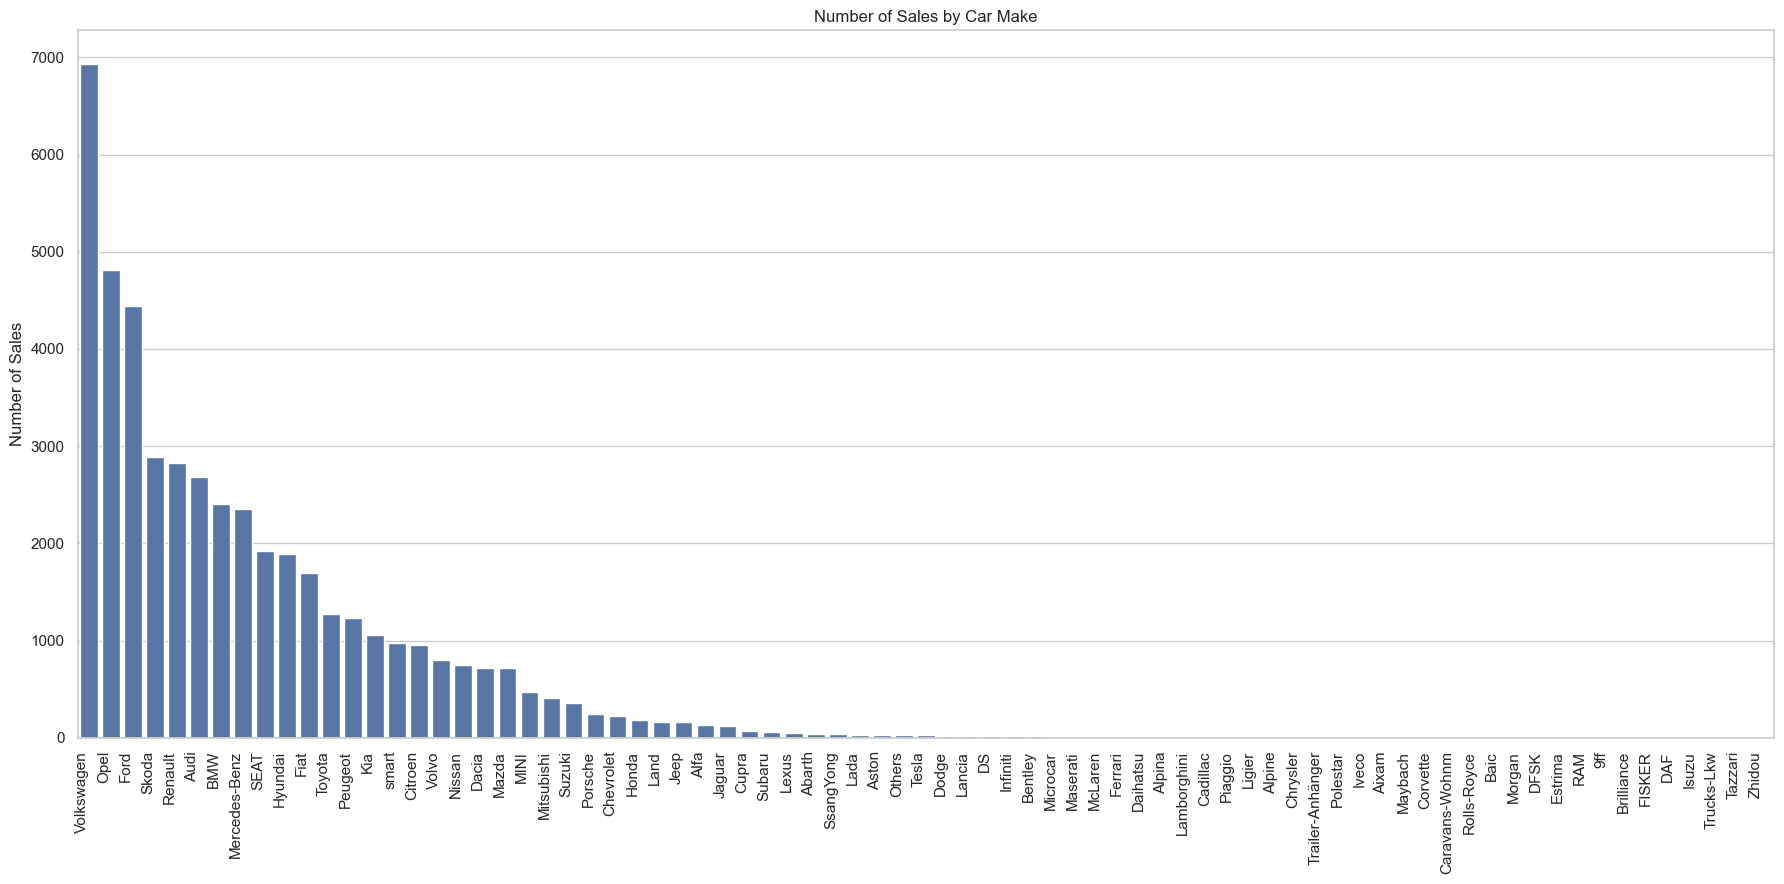

In [56]:
# Set the style for seaborn
sns.set_theme(style="whitegrid")

# Set up the matplotlib figure for each variable
plt.figure(figsize=(18, 9))

# Create a barplot for the current variable
sns.barplot(x='Level', y='Count', data=counts_df[counts_df['Variable'] == 'make'])
# Customize the plot
plt.title(f'Number of Sales by Car Make')
plt.xlabel('')
plt.ylabel('Number of Sales')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot for the current variable
plt.tight_layout()
plt.show()

The majority of sales are attributed to the first 20 to 30 car makes, while all other brands hold a relatively insignificant share in terms of sales volume.

Plot number of sales by car models.

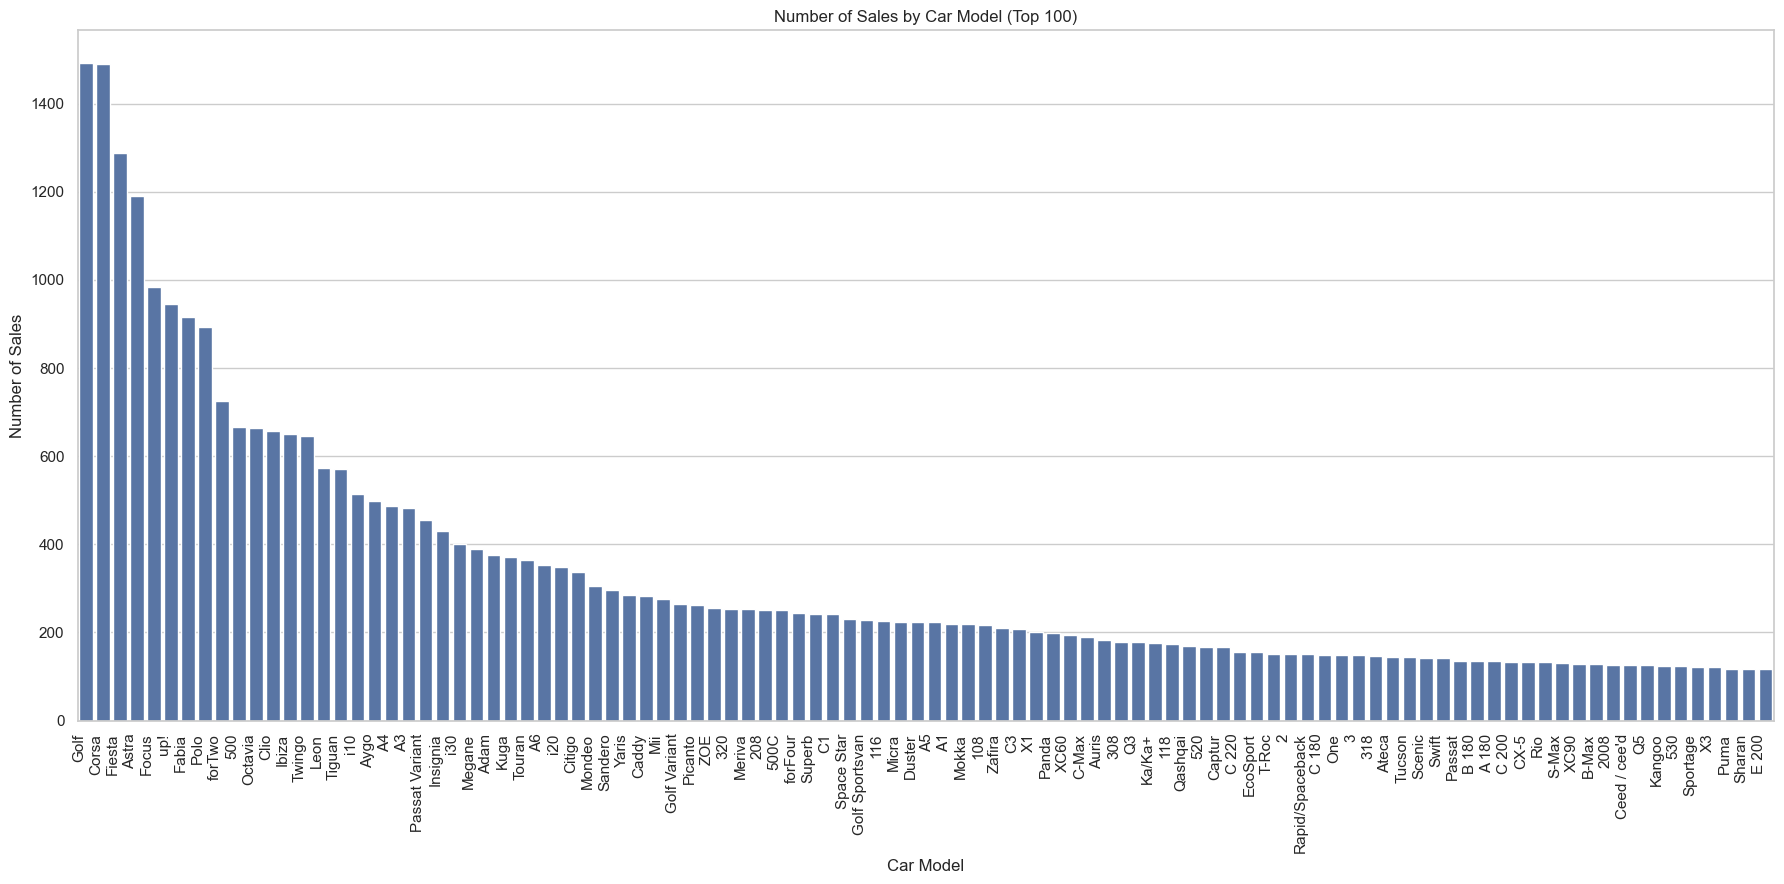

In [57]:
# Filter data for the 'model' variable
model_data = counts_df[counts_df['Variable'] == 'model']

# Sort the models by count in descending order
top_models = model_data.sort_values(by='Count', ascending=False).head(100)

# Set up the matplotlib figure for each variable
plt.figure(figsize=(18, 9))

# Create a barplot for the top models
sns.barplot(x='Level', y='Count', data=top_models)
# Customize the plot
plt.title(f'Number of Sales by Car Model (Top 100)')
plt.xlabel('Car Model')
plt.ylabel('Number of Sales')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot for the top models
plt.tight_layout()
plt.show()

The sales show a rapid decline over the the top 50 models, with a much slower decline for the following 50 models.

Plot number of sales by fuel type.

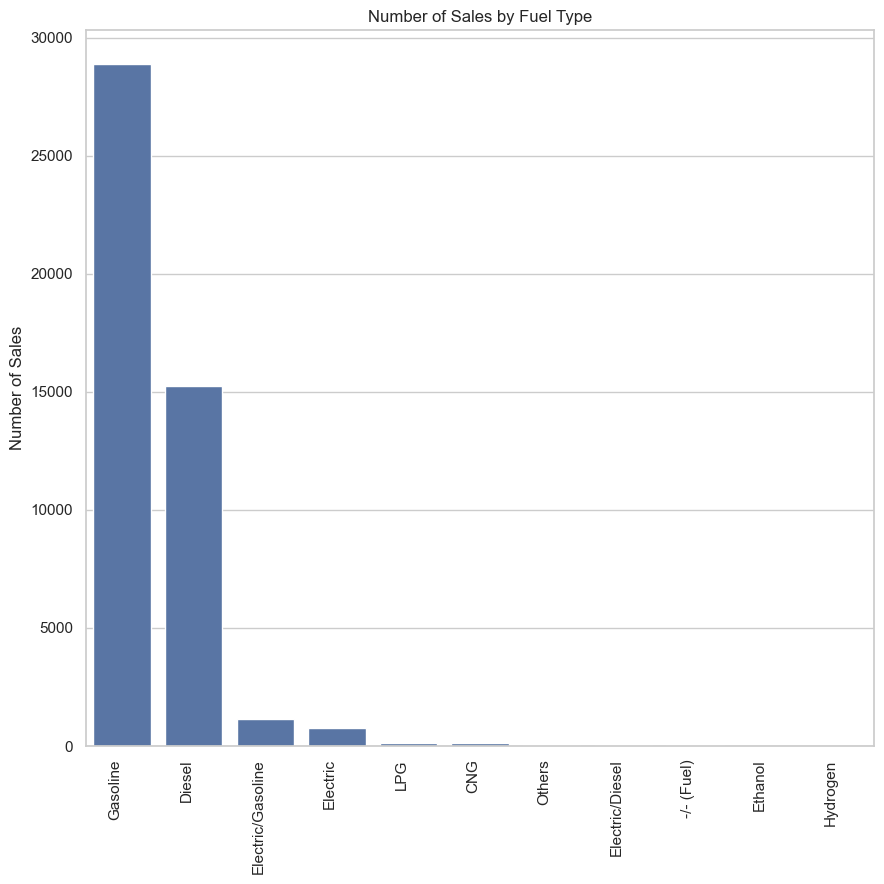

In [58]:
# Set the style for seaborn
sns.set_theme(style="whitegrid")

# Set up the matplotlib figure for each variable
plt.figure(figsize=(9, 9))

# Create a barplot for the current variable
sns.barplot(x='Level', y='Count', data=counts_df[counts_df['Variable'] == 'fuel'])
# Customize the plot
plt.title(f'Number of Sales by Fuel Type')
plt.xlabel('')
plt.ylabel('Number of Sales')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot for the current variable
plt.tight_layout()
plt.show()

Gasoline and diesel are the most widely used types of fuel, while all other types of fuel account for a relatively insignificant share of sales volumes.

Plot number of sales by gear type.

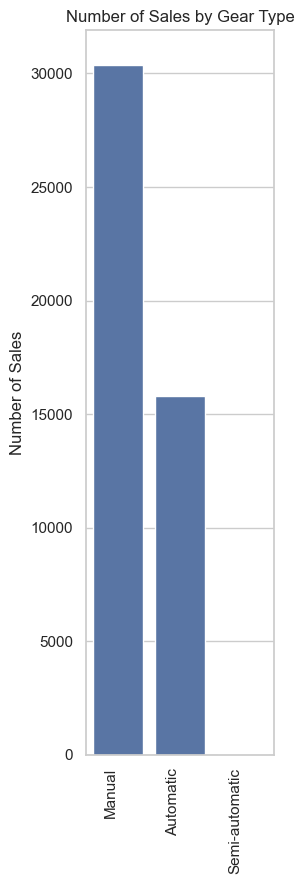

In [59]:
# Set the style for seaborn
sns.set_theme(style="whitegrid")

# Set up the matplotlib figure for each variable
plt.figure(figsize=(3, 9))

# Create a barplot for the current variable
sns.barplot(x='Level', y='Count', data=counts_df[counts_df['Variable'] == 'gear'])
# Customize the plot
plt.title(f'Number of Sales by Gear Type')
plt.xlabel('')
plt.ylabel('Number of Sales')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot for the current variable
plt.tight_layout()
plt.show()

Manual and automatic are the most widely used gear types, while semi-automatic accounts for a relatively insignificant share of sales volumes.

Plot number of sales by offer type.

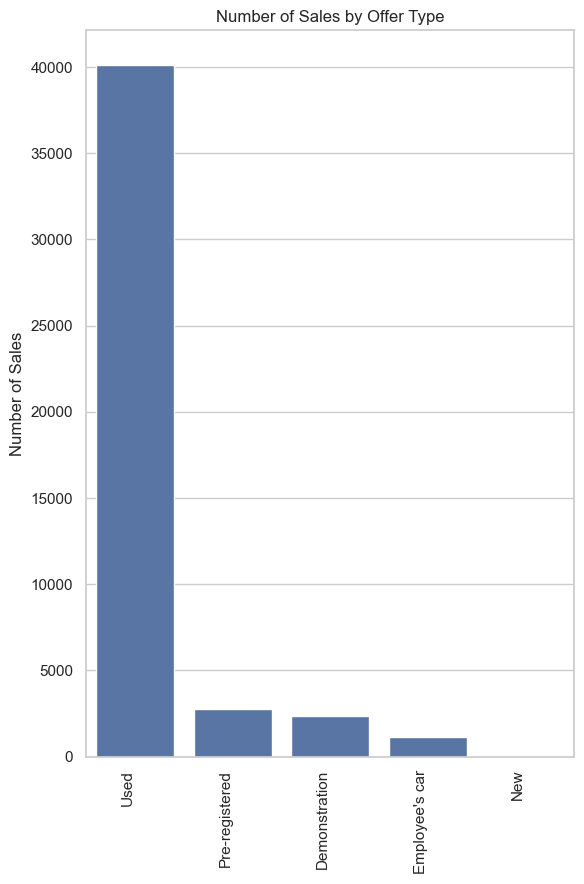

In [69]:
# Set the style for seaborn
sns.set_theme(style="whitegrid")

# Set up the matplotlib figure for each variable
plt.figure(figsize=(6, 9))

# Create a barplot for the current variable
sns.barplot(x='Level', y='Count', data=counts_df[counts_df['Variable'] == 'offerType'])
# Customize the plot
plt.title(f'Number of Sales by Offer Type')
plt.xlabel('')
plt.ylabel('Number of Sales')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot for the current variable
plt.tight_layout()
plt.show()

Used cars dominate sales by a significant margin, while sales of other offer types are comparatively minor.

### 2.3.2. Target distribution by categorical levels

## 2.4. Continuous Variables

### 2.4.1. Correlation

### 2.4.2. Linearity

### 2.4.3. Distribution

### 2.4.4. Outliers